# MahyarMohammadi-610398166-Genetic Algorithm for TSP

### First let's import some librarys

In [2]:
import numpy as np
import pandas as pd
import matplotlib as plt
import random
from math import sqrt

### This function will get the testcase bayg29

In [3]:
def getMat(path):
    #get from directory
    f = open(path)
    inp = f.read()
    f.close()
    
    #decode data and cleaning
    size = int(inp.split('\n')[3].split(':')[-1].strip())
    inpMat = [[int(item.strip()) for item in row.strip().split()] for row in inp.split('\n')[8:36]]
    
    #make adjacency matrix
    mat = [[0 for _ in range(size)] for _ in range(size)]
    for i in range(size-1):
        for j in range(size-i-1):
            mat[i][j+i+1] = inpMat[i][j]
            mat[j+i+1][i] = inpMat[i][j]
            
    return size,mat

### Define fitness function

In [45]:
def fitFunc(chromosome):
    path=0
    for i in range(size):
        gene1 = chromosome[i]
        gene2 = chromosome[i+1 if(i+1<size) else 0]
        path+=mat[gene1][gene2]
    return 10000-path

In [68]:
a = [14, 17, 13, 16, 21, 10, 18, 24, 6, 22, 26, 7, 23, 15, 12, 0, 27, 5, 11, 8, 25, 2, 28, 4, 20, 1, 19, 9, 3]
10000-fitFunc(a)

1620

### select first society

In [5]:
def getSociety():
    chromosomes = [np.random.permutation(range(size)) for _ in range(sp)]
    fitnesses = [fitFunc(chromosome) for chromosome in chromosomes]
    society = pd.DataFrame({'chromosomes':chromosomes,'fitnesses':fitnesses})
    society = society.sort_values(by='fitnesses').reset_index().drop(['index'],axis=1)
    return society

### Define 2 Selection functions

In [6]:
#select choromosoms that have more fitnesses score than the input quantile
def truncation_selection(society):
    return society.tail(int(pc*len(society)/100))

#select choromosoms with probablity based on their ranks 
def proportional_selection(society):
    size = int(pc*len(society)/100)
    soc = society.copy()
    tot = sum(range(len(soc)))
    probs = [i/tot for i in range(len(soc))]
    selected = np.random.choice(list(range(len(soc))),size,p=probs,replace=False)

    selected = list(selected)+list(range(len(soc)))[int(0.09*len(soc)):]
    selected = selected[len(selected):len(selected)-size-1:-1]

    return soc.loc[selected,]


### here we define Crossover function

In [29]:
def generate_children(parents):
    #Order Recombination
    def orderRec(couple):
        dad,mom = couple
        child = [-1]*len(dad)
        middle = len(dad)//2
        k = middle//2

        start = middle-k if middle-k>0 else 0
        end = middle+k
        dadInherit = dad[start:end]
        child[start:end]=dadInherit
        child_set = set(child)
        i=end
        j=end
        while(i!=start):
            if(i==len(dad)):i=0
            while(mom[j] in child_set):j = j+1 if j+1!=len(mom) else 0
            child_set.add(mom[j])
            child[i] = mom[j]
            i+=1
        return child
        
        
    #first set couples
    def getCouples(parents):
        shuffle = np.random.choice(parents.chromosomes,len(parents),replace=False)
        return tuple(zip(shuffle[:len(shuffle)//2],shuffle[len(shuffle)//2:]))
    
    #Mutation
    def mutation(children):
        #Scramble Mutation
        def mutate(child):
            i,j = np.random.choice(list(range(len(child))),2,replace=False)
            if(i>j): i,j = j,i
            child[i:j] = np.random.choice(child[i:j],j-i,replace=False)
            return
        
        #Scramble Reverse Mutation
        def mutate2(child):
            i,j = np.random.choice(list(range(len(child))),2,replace=False)
            if(i>j): i,j = j,i
            child[i:j] = child[j:i:-1]
            return
            
        for i in range(len(children)*mutRate//100):
            mutate(children[i])
        
        return 

    count = sp*Prep//100
    #now apply crossover function on each couple and create children until we get the number of children we want
    children=[]

    while(len(children)<count):
        coups = getCouples(parents)
        children=children+[orderRec(t) for t in coups]

    mutation(children)

    fitnesses = [fitFunc(child) for child in children]
    
    return pd.DataFrame({'chromosomes':children,'fitnesses':fitnesses}).head(count)

### get society and children and combine them

In [8]:
def newGeneration(society,children):
    res = pd.concat([children,society.loc[range(len(children),len(society))]],axis=0)
    return res.sort_values(by='fitnesses').reset_index().drop(['index'],axis=1)


### print society statistic

In [9]:
def societyStat(society):
    stat = society.fitnesses
    return int(10000-stat.mean()),10000-stat.max()

### Run GA with Parameters that set Globaly

In [79]:
def runAlgorithm(selectMethod='truncation'):
    society = getSociety()
    socMean,socMin = societyStat(society)
    print(f"the first generation-> Mean:{socMean},Min:{socMin}")
    means=[socMean]
    mins=[socMin]
    repetead = 0
    lastMin = -1
    i=0
    while(repetead<200):
        parents = truncation_selection(society) if selectMethod=='truncation' else proportional_selection(society)
        childs = generate_children(parents)
        newSociety = newGeneration(society,childs)
        socMean,socMin = societyStat(newSociety)
        means.append(socMean)
        mins.append(socMin)
        if((i+2)%1==0):print(f"the {i+2}th generation-> Mean:{socMean},Min:{socMin}")
        i+=1
        society = newSociety

        if(lastMin!=socMin):
            repetead=0
            lastMin=socMin
        else:repetead+=1
    print(f"the {i+2}th(last) generation-> Mean:{socMean},Min:{socMin}")
    df = pd.DataFrame({'Mean':means,'min':mins})
    df.plot()
    print("best cycle:",society[society.fitnesses==society.fitnesses.max()]['chromosomes'].values[0])
    return society

### this is where we config our algorithm with various parameters

the first generation-> Mean:4690,Min:3802
the 50th generation-> Mean:2549,Min:2489
the 100th generation-> Mean:2252,Min:2174
the 126th(last) generation-> Mean:2219,Min:2174
best cycle: [26, 22, 6, 24, 15, 23, 27, 0, 18, 14, 3, 9, 12, 5, 11, 8, 4, 28, 2, 25, 20, 19, 17, 13, 16, 21, 10, 1, 7]


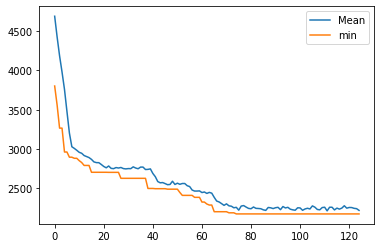

In [67]:
#these are our algorithm config

#TSP adjecency matrix
size,mat = getMat('bayg29.tsp')

#society population
sp = 200

#what percent of society should we choose as parents?
pc = 30

#the percent of previuos generation that replace with children on next generation
Prep = 80

#the percent of children that get mutated
mutRate = 10

res = runAlgorithm()

The convergence is too fast so we can incraese mutation rate 

----------------------------------------------------------------------------------------------------------------------

In [ ]:
size,mat = getMat('bayg29.tsp')

sp = 200
pc = 30
Prep = 80
mutRate = 20

res = runAlgorithm()

it's not very effective. let's increase our generation population and use proportional method for selecting

----------------------------------------------------------------------------------------------------------------------

In [ ]:
size,mat = getMat('bayg29.tsp')

sp = 1000
pc = 50
Prep = 50
mutRate = 10

res = runAlgorithm('proportional')

the first generation-> Mean:4724,Min:3687
the 10th generation-> Mean:3821,Min:3201
the 20th generation-> Mean:3425,Min:3020
the 30th generation-> Mean:3005,Min:2492
the 40th generation-> Mean:2645,Min:2348
the 50th generation-> Mean:2399,Min:2330
the 60th generation-> Mean:2351,Min:2175
the 70th generation-> Mean:2212,Min:2102
the 80th generation-> Mean:2143,Min:2071
the 90th generation-> Mean:2125,Min:2010
the 100th generation-> Mean:2058,Min:1976
the 110th generation-> Mean:2022,Min:1960
the 120th generation-> Mean:2014,Min:1960
best cycle: [26, 22, 18, 14, 3, 7, 21, 1, 28, 13, 20, 19, 16, 15, 4, 10, 6, 25, 12, 8, 9, 17, 23, 24, 0, 27, 2, 5, 11]


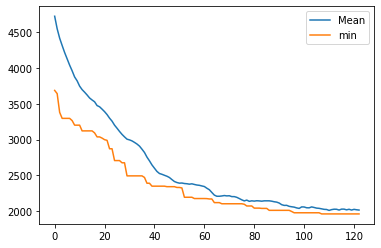

In [90]:
size,mat = getMat('bayg29.tsp')

sp = 1000
pc = 50
Prep = 50
mutRate = 10

res = runAlgorithm('proportional')

it's get better! now let's increase population more

----------------------------------------------------------------------------------------------------------------------

the first generation-> Mean:4741,Min:3419
the 30th generation-> Mean:3136,Min:2229
the 60th generation-> Mean:2150,Min:2046
the 90th generation-> Mean:2037,Min:1936
the 120th generation-> Mean:1993,Min:1885
the 150th generation-> Mean:1996,Min:1885
the 151th(last) generation-> Mean:1996,Min:1885
best cycle: [23, 7, 26, 22, 6, 24, 18, 15, 1, 9, 3, 14, 10, 21, 16, 13, 17, 19, 20, 0, 27, 5, 11, 8, 4, 25, 2, 28, 12]


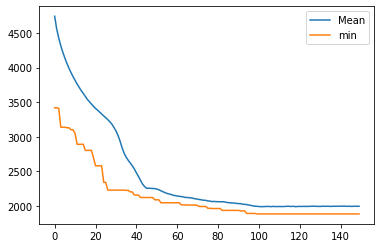

In [60]:
size,mat = getMat('bayg29.tsp')

sp = 10000
pc = 40
Prep = 30
mutRate = 10

res = runAlgorithm('proportional')

the first generation-> Mean:4731,Min:3098
the 30th generation-> Mean:2854,Min:2460
the 60th generation-> Mean:2356,Min:2153
the 90th generation-> Mean:2125,Min:1987
the 120th generation-> Mean:1999,Min:1968
the 150th generation-> Mean:2000,Min:1968
the 163th(last) generation-> Mean:1998,Min:1968
best cycle: [28, 8, 11, 27, 7, 26, 22, 6, 24, 18, 15, 12, 23, 0, 5, 20, 1, 2, 17, 13, 16, 21, 10, 14, 3, 9, 19, 4, 25]


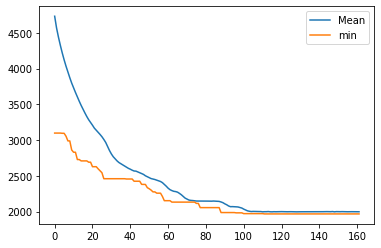

In [61]:
size,mat = getMat('bayg29.tsp')

sp = 10000
pc = 20
Prep = 20
mutRate = 10

res = runAlgorithm('proportional')

it's get a lot better! 

----------------------------------------------------------------------------------------------------------------------

## Extra Parts

### This function decode gr229 file to adjacency matrix

In [62]:
def getMat2(path):
    def dist(i,j):
        res = sqrt((nodes[i][0]-nodes[j][0])**2+(nodes[i][1]-nodes[j][1])**2)
        return int(res)
    
    f = open(path)
    inp = f.read()
    f.close()
    nodes = [(float(e.split()[1]),float(e.split()[2])) for e in inp.split('\n')[7:-2]]
    mat = [[dist(i,j) for j in range(len(nodes))] for i in range(len(nodes))]
    return len(mat),mat

the first generation-> Mean:15808,Min:13890
the 50th generation-> Mean:11997,Min:10932
the 100th generation-> Mean:10299,Min:10032
the 150th generation-> Mean:9623,Min:9424
the 200th generation-> Mean:9238,Min:9046
the 250th generation-> Mean:8820,Min:8643
the 300th generation-> Mean:8481,Min:8338
the 350th generation-> Mean:8230,Min:8012
the 400th generation-> Mean:7858,Min:7688
the 450th generation-> Mean:7589,Min:7443
the 500th generation-> Mean:7385,Min:7233
the 550th generation-> Mean:7203,Min:7076
the 600th generation-> Mean:7038,Min:6907
the 650th generation-> Mean:6818,Min:6700
the 700th generation-> Mean:6704,Min:6591
the 750th generation-> Mean:6615,Min:6497
the 800th generation-> Mean:6489,Min:6360
the 850th generation-> Mean:6372,Min:6234
the 900th generation-> Mean:6281,Min:6154
the 950th generation-> Mean:6183,Min:6071
the 1000th generation-> Mean:6073,Min:5962
the 1050th generation-> Mean:6007,Min:5886
the 1100th generation-> Mean:5919,Min:5805
the 1150th generation-> Me

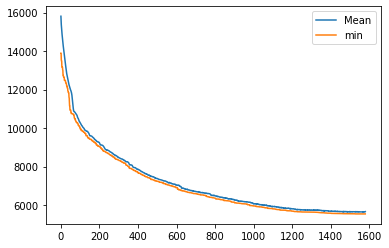

In [72]:
size,mat = getMat2('gr229.tsp')

sp = 1000
pc = 60
Prep = 40
mutRate = 5

res = runAlgorithm('proportional')

This is the best i can get out of this testcase!

In [69]:
def getMat3(path):
    def dist(i,j):
        res = sqrt((nodes[i][0]-nodes[j][0])**2+(nodes[i][1]-nodes[j][1])**2)
        return int(res)
    
    f = open(path)
    inp = f.read()
    f.close()

    nodes = [(float(e.split()[1]),float(e.split()[2])) for e in inp.split('\n')[6:-1]]

    mat = [[dist(i,j) for j in range(len(nodes))] for i in range(len(nodes))]
    return len(mat),mat

the first generation-> Mean:6450633,Min:6232338
the 200th generation-> Mean:5389304,Min:5308920
the 400th generation-> Mean:5080881,Min:5019482
the 600th generation-> Mean:4865058,Min:4799816
the 800th generation-> Mean:4730613,Min:4650097
the 1000th generation-> Mean:4651299,Min:4570462
the 1200th generation-> Mean:4576336,Min:4510439
the 1400th generation-> Mean:4505364,Min:4418584
the 1600th generation-> Mean:4445883,Min:4350990
the 1800th generation-> Mean:4383312,Min:4309761
the 2000th generation-> Mean:4357053,Min:4250404
the 2200th generation-> Mean:4295704,Min:4195366
the 2400th generation-> Mean:4242376,Min:4148477
the 2600th generation-> Mean:4188452,Min:4090676
the 2800th generation-> Mean:4116219,Min:4023812
the 3000th generation-> Mean:4072166,Min:3979081
the 3200th generation-> Mean:4042387,Min:3952890
the 3400th generation-> Mean:4008714,Min:3894586
the 3456th(last) generation-> Mean:3981948,Min:3886342
best cycle: [864, 441, 316, 425, 963, 794, 575, 476, 303, 122, 121, 

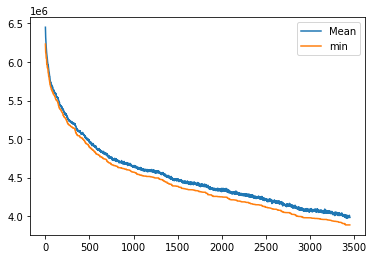

In [75]:
size,mat = getMat3('pr1002.tsp')

sp = 500
pc = 40
Prep = 50
mutRate = 20

res = runAlgorithm('proportional')

----------------------------------------------------------------------------------------------------------------------

## So what just happend?



we should control mean and minimum. when mean get so close to minimum of a generation, this means that the standard deviation is low and the genetic diversity of our generation is low. So the convergence happend very quickly on some local result and the algorithm stop searching for better generation.
in this case we can do this things:
1. increase mutation rate
2. increase the percent of choromosoms that choose to be parents not just the better one.
3. decrease the replacement rate and save more choromosoms from previous generation

also we can get better result by decreasing our generation population. 